### Detect overlapping between sources in cosmoDC2 and the object catalog

In [1]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Ellipse
from astropy.table import Table

#### The Ellipse Equation: (https://en.wikipedia.org/wiki/Ellipse#General_ellipse , but swapping B and C)

$$
A x^2 + B y^2 + C x y +  D x +  E y + F = 0
$$
where 

$
\begin{align}
A & = a^2\sin^2{\theta} +  b^2\cos^2{\theta},  \\
B & = a^2\cos^2{\theta} +  b^2\sin^2{\theta}, \\
C & = 2(b^2 - a^2)\sin{\theta}\cos{\theta}, \\
D & = -2Ax_0 - Cy_0,  \\
E & = -C x_0 - 2B y_0,  \\
F & = Ax_0^2 + C x_0 y_0 + By_0^2 - a^2 b^2. 
\end{align}
$

$x_0, y_0$ are the coordinates for the ellipse center, $a$, $b$ the semi-major/minor axis and $\theta$ the position angle (the angle between the major axis and ra for the extragalactic catalog, and between the major axis and CCD x axis for the object catalog).

#### following the definitions of https://www.sciencedirect.com/science/article/abs/pii/S0167839617300791 (hereafter AC2017):  
shrink the parameters CDE by half,

$$ C = C / 2, \quad D = D / 2, \quad E = E / 2, $$

and modify the Ellipse Equation:

$$
A x^2 + B y^2 + 2C x y + 2 D x + 2 E y + F = 0.
$$




In [2]:
def ellipse_equation(x, y, A, B, C, D, E, F):
    return A*x**2 + B*y**2 + 2*C*x*y + 2*D*x + 2*E*y + F

def is_overlapping(p1, p2):
    A1, B1, C1, D1, E1, F1 = p1
    A2, B2, C2, D2, E2, F2 = p2
    
    M1 = [[A1, C1, D1], [C1, B1, E1], [D1, E1, F1]]
    M2 = [[A2, C2, D2], [C2, B2, E2], [D2, E2, F2]]
    
    l0 = np.linalg.det(M2)
    l1 = (np.linalg.det([[A1,C2,D2],[C1,B2,E2],[D1,E2,F2]]) +
            np.linalg.det([[A2,C1,D2],[C2,B1,E2],[D2,E1,F2]]) +
            np.linalg.det([[A2,C2,D1],[C2,B2,E1],[D2,E2,F1]])) / 3
    l2 = (np.linalg.det([[A2,C1,D1],[C2,B1,E1],[D2,E1,F1]]) +
            np.linalg.det([[A1,C2,D1],[C1,B2,E1],[D1,E2,F1]]) +
            np.linalg.det([[A1,C1,D2],[C1,B1,E2],[D1,E1,F2]])) / 3
    l3 = np.linalg.det(M1)

    delta1 = np.linalg.det([[l3, l2],[l2, l1]])
    delta2 = np.linalg.det([[l3, l1],[l2, l0]])
    delta3 = np.linalg.det([[l2, l1],[l1, l0]])
    discriminant_P = np.linalg.det([[2*delta1, delta2], [delta2, 2*delta3]])
    
    if (discriminant_P >=0) and ((l1>0) or (l2>0)):
        return False  ## not over-lapping
    else:
        return True

### To get the Ellipse parameters ABCDEF from the Extragalactic Catalog (a small patch in cosmoDC2):
$
a = size, \quad b = size\_minor, \quad \theta = position\_angle.
$

In [4]:
truth = Table.read('cluster_truth.fits', format='fits')
print(truth.columns)

<TableColumns names=('id','ra','dec','mag_i','mag_r','redshift','a_true','b_true','theta','e1_lensed','e2_lensed','star')>


In [8]:
x0 = truth['ra']
y0 = truth['dec']
a = truth['a_true'] / 3600.  ## arcsec to degree
b = truth['b_true'] / 3600.  ## arcsec to degree
theta = np.radians(truth['theta'])

sin = np.sin(theta)
cos = np.cos(theta)

truth['A'] = (a*sin)**2 + (b*cos)**2
truth['B'] = (a*cos)**2 + (b*sin)**2

C = 2*(b**2 - a**2)*sin*cos
D = -2*truth['A']*x0 - C*y0
E = -C*x0 - 2*truth['B']*y0

truth['F'] = truth['A']*x0**2 + C*x0*y0 + truth['B']*y0**2 - (a*b)**2
truth['C'], truth['D'], truth['E'] = C/2, D/2, E/2

print(len(truth), len(x0))

4430 4430


#### plot some sources (enlarge the size by 100 for visulizaiton)

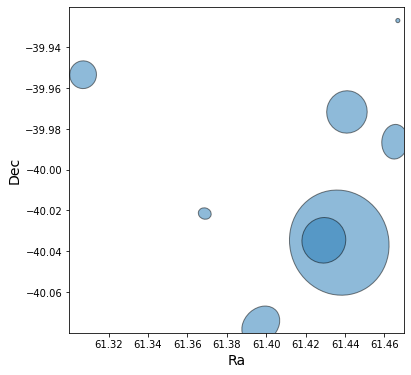

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, xlim=(truth['ra'].min(), truth['ra'].max()), 
                     ylim=(truth['dec'].min(),truth['dec'].max()))
ax.set_xlabel('Ra', fontsize=14)
ax.set_ylabel('Dec', fontsize=14)

N = len(truth)
for i in np.random.randint(0, high=N, size=10):
    ellipse = Ellipse((truth['ra'][i],truth['dec'][i]), 
                      width=100*2*truth['a_true'][i]/3600., height=100*2*truth['b_true'][i]/3600., 
                      angle=truth['theta'][i], edgecolor='k', alpha=0.5, linewidth=1)
    ax.add_artist(ellipse)

### Now the object catalog

In [10]:
obj = Table.read('cluster_obj.fits', format='fits')
print(obj.columns)

<TableColumns names=('photoz_mode','mag_r_cModel','mag_i_cModel','blendedness','dec','ra','Iyy_pixel','x','y','Ixx_pixel','Ixy_pixel')>


#### verify the pixel scale (it's 0.2''/pix from https://arxiv.org/pdf/2010.05926.pdf)

In [11]:
N = len(obj)
i = np.random.randint(0, high=N)
j = np.random.randint(0, high=N)
print('pixel scale caculated from pair sources:', (i, j), '/', N)

x1, y1 = obj['x'][i], obj['y'][i]
x2, y2 = obj['x'][j], obj['y'][j]
dist_pixel = np.sqrt( (x1-x2)**2 + (y1-y2)**2 )

ra1, dec1 = np.radians(obj['ra'][i]), np.radians(obj['dec'][i])
ra2, dec2 = np.radians(obj['ra'][j]), np.radians(obj['dec'][j])

cos_dist = np.sin(dec1)*np.sin(dec2) + np.cos(dec1)*np.cos(dec2)*np.cos(ra1-ra2)
dist_rad = np.arccos(cos_dist)
dist_arcsec = np.degrees(dist_rad)*3600

pixel_ratio = dist_arcsec / dist_pixel
print('pixel scale:', pixel_ratio, 'arcsec/pix')

pixel scale caculated from pair sources: (1833, 1951) / 2034
pixel scale: 0.19998725234600392 arcsec/pix


#### To get the Ellipse parameters ABCDEF from the Object Catalog:
based on my calculation, for perfect ellipses with constant flux,
$$ 
\begin{align}
I_{xx} & = \frac{\pi}{4}ab \left( a^2\cos^2{\theta} + b^2\sin^2{\theta} \right), \\
I_{yy} & = \frac{\pi}{4}ab \left( a^2\sin^2{\theta} + b^2\cos^2{\theta} \right), \\ 
I_{xy} & = \frac{\pi}{4}ab \left( a^2 - b^2 \right) \cos{\theta}\sin{\theta}.
\end{align}
$$
therefore,
$$ 
\begin{align}
I_{xx}I_{yy} - I^2_{xy} 
    & = \frac{\pi^2}{16}a^2 b^2 
    \left[ \left( a^2\cos^2{\theta} + b^2\sin^2{\theta} \right) 
    \left( a^2\sin^2{\theta} + b^2\cos^2{\theta} \right) -
    \left( a^2 - b^2 \right)^2 \cos^2{\theta}\sin^2{\theta} \right] \\
    & = \frac{\pi^2}{16}a^4 b^4
\end{align}
$$
or

$ \pi ab = 2\sqrt{\pi} \left( I_{xx}I_{yy} - I^2_{xy} \right)^{1/4}. $

Furthermore, 

$
\begin{align}
A & = a^2\sin^2{\theta} +  b^2\cos^2{\theta} = \frac{4I_{yy}}{\pi ab},  \\
B & = a^2\cos^2{\theta} +  b^2\sin^2{\theta} = \frac{4I_{xx}}{\pi ab}, \\
C & = 2(b^2 - a^2)\sin{\theta}\cos{\theta} = \frac{-8I_{xy}}{\pi ab}, \\ 
\end{align}
$

and D, E, F follows.

In [12]:
x0 = obj['ra']
y0 = obj['dec']

Ixx = obj['Ixx_pixel'] * (0.2 / 3600.)**4    ## in degrees
Iyy = obj['Iyy_pixel'] * (0.2 / 3600.)**4    ## in degrees
Ixy = obj['Ixy_pixel'] * (0.2 / 3600.)**4    ## in degrees

pi_ab = 2 * np.sqrt(np.pi) * np.power(Ixx*Iyy - Ixy**2, 1/4)

obj['A'] = 4*Iyy/pi_ab
obj['B'] = 4*Ixx/pi_ab
obj['C'] = -8*Ixy/pi_ab

D = -2*obj['A']*x0 - obj['C']*y0
E = -obj['C']*x0 - 2*obj['B']*y0

obj['F'] = obj['A']*x0**2 + obj['C']*x0*y0 + obj['B']*y0**2 - (pi_ab/np.pi)**2
obj['C'], obj['D'], obj['E'] = obj['C']/2, D/2, E/2

#### plot some sources (enlarge the size by unknow ratio for visulizaiton)

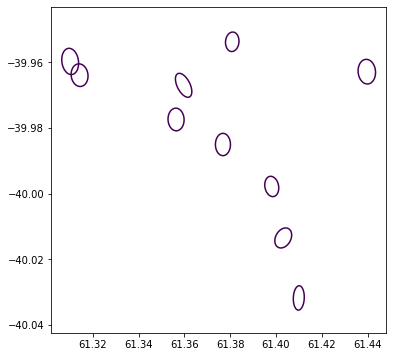

In [13]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)
N = len(obj)

for i in np.random.randint(0, high=N, size=10):

    rough_size = 100 * np.sqrt( pi_ab[i]/np.pi )
    x = np.linspace(obj['ra'][i]-rough_size, obj['ra'][i]+rough_size, 100)
    y = np.linspace(obj['dec'][i]-rough_size, obj['dec'][i]+rough_size, 100)
    x, y = np.meshgrid(x,y)
    z = ellipse_equation(x, y, obj['A'][i], obj['B'][i], obj['C'][i], obj['D'][i], obj['E'][i], obj['F'][i])
    
    #ax.contour(x, y, z, [0])      ## the true size
    ax.contour(x, y, z, [1e-13])

### Match the two catalogs with KD tree